# Occupancy Prediction from Six Features

This project is about predicting room occupancy from given six features, which are 'date',  'Temperature', 'Humidity', 'Light', 'CO2' and 'HumidityRatio'. The dataset is from UCI repository. And the dataset link is shown here.
https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

A separate 'testing dataset' is provided in the same folder as the 'training dataset', for validating the performance of model constructed in this notebook.

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr
from scipy.stats import entropy

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

import joblib

Load the dataset into Jupyter notebook as a Dataframe. And observe its shape.

In [2]:
occu = pd.read_csv('datatraining.txt')
print(occu.shape)
occu.head(2)

(8143, 7)


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1


To observe what the data of each feature and target look like. From that observation, an initial knowledge on the data type can be achieved.

In [3]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(occu)

date 
 ['2015-02-04 17:51:00' '2015-02-04 17:51:59' '2015-02-04 17:53:00' ...
 '2015-02-10 09:30:59' '2015-02-10 09:32:00' '2015-02-10 09:33:00'] 

Temperature 
 [19.         19.05       19.1        19.13333333 19.15       19.16666667
 19.175      19.2        19.2225     19.23       19.245      19.26
 19.2675     19.272      19.29       19.315      19.32333333 19.34
 19.35       19.35666667 19.365      19.39       19.412      19.4175
 19.42666667 19.434      19.445      19.46333333 19.4725     19.5
 19.525      19.53333333 19.55       19.56666667 19.575      19.58
 19.6        19.625      19.63333333 19.65       19.66666667 19.675
 19.68       19.7        19.7225     19.73       19.745      19.76
 19.7675     19.79       19.815      19.82333333 19.84       19.85666667
 19.865      19.89       19.9175     19.92666667 19.945      19.96333333
 19.9725     20.         20.025      20.03333333 20.05       20.06666667
 20.075      20.1        20.125      20.13333333 20.15       20.16666667
 2

The results shown above demonstrates that the data type of target 'Occupancy' is binary. The data type of each feature is numerical. 

And the next code block deciphers the data type by counting the number of unique values in each feature. And the number of missing value cells, as well as its percentage to the corresponding feature is also calculated.

In [4]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = snapshot(occu)
snapshot

,n_unique,dtype,n_missing,pct_missing
date,8143,object,0,0.0
Temperature,265,float64,0,0.0
Humidity,1325,float64,0,0.0
Light,889,float64,0,0.0
CO2,2282,float64,0,0.0
HumidityRatio,3583,float64,0,0.0
Occupancy,2,int64,0,0.0


The table above shows no missing values in this dataset. 
And the number of unique values in each feature reinforces the judgement that the data type in each feature is numerical.

In [5]:
occu['Occupancy'] = occu['Occupancy'].astype(str)

To observe the distribution of target by drawing a bar plot.

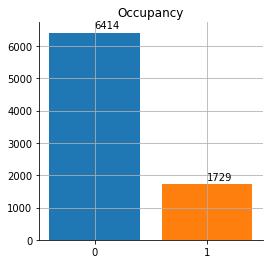

In [6]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()
    
plot_single_categorical(occu, 'Occupancy')

The bar graph above shows the target is unbalanced with label '0' being almost three times more than the other label. An appropriate metric should be chosen to measure the performance of algorithms considering target being unbalanced.

In [7]:
numer = occu.columns.drop(['date', 'Occupancy'])

Draw scatter graphs to obtain the information on:
1. Whether outliers exist;
2. Whether the target samples could be clustered by the given features.

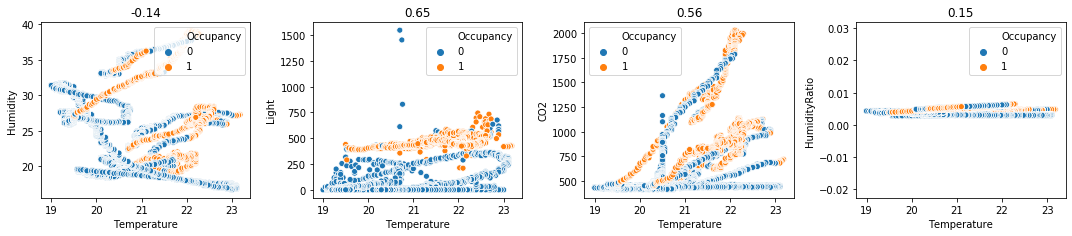

In [8]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()
    
scatter_fea_corr_classif_targ(occu, numer.tolist(), 'Occupancy')

Five features, 'Temperature', 'Humidity', 'Light', 'CO2' and 'HumidityRatio' are studied from the graphs above.

'Temperature' is observed from the horizontal axis, and the other four features are observed from the four vertical axes respectively.

The graph group above shows that
1. outliers exist with most of them coming from feature 'Light';
2. The feature 'Light' performs well in separating the target labels with most of orange dots being upper and blue dots being lower in the second graph.

By using the code bock below, obtain the indexes of outlier samples and count the number of them.

In [9]:
def outlier_index(df, features):
    index_outlier = pd.DataFrame().index
    
    for feature in features:
        minimum = np.quantile(df[feature], 0.25) - 1.5 * iqr(df[feature])
        index_outlier = index_outlier.append(df[df[feature] < minimum].index)
        maximum = np.quantile(df[feature], 0.75) + 1.5 * iqr(df[feature])
        index_outlier = index_outlier.append(df[df[feature] > maximum].index)
    
    index_outlier = index_outlier.drop_duplicates(keep = 'first')
    return index_outlier

index_outlier = outlier_index(occu, numer)
print(f'There are {len(index_outlier)} outlier samples.')
index_outlier.sort_values()

There are 1066 outlier samples.


Int64Index([ 932,  933,  934,  935,  936,  937,  938,  939,  940,  941,
            ...
            7338, 7339, 7340, 7341, 7342, 7343, 7344, 7461, 7463, 7464],
           dtype='int64', length=1066)

The code block gives the indexes of outlier samples and the number of them.

Next, drop the outlier samples from the dataset.

In [10]:
occu.drop(index_outlier, inplace = True)
occu.shape

(7077, 7)

Draw the scatter graphs again for the datset without outlier samples.

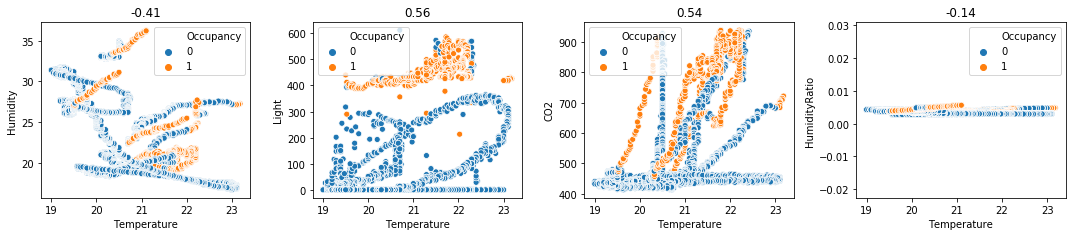

In [11]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()
    
scatter_fea_corr_classif_targ(occu, numer.tolist(), 'Occupancy')

From the four graphs above, it is even more obvious that 'Light' is a rather helpful feature to separate the two target labels. A gap appears between two clusters in the second graph after outlier samples being removed.

However, it seems that none of the other four features is meaningful in clustering target labels.

A bar graph showing target distribution is to be plotted again after outlier samples being removed.

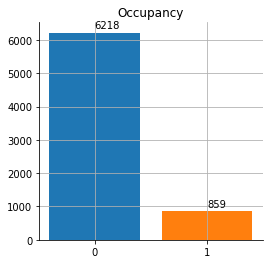

In [12]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()
    
plot_single_categorical(occu, 'Occupancy')

The bar graph above shows the target is even more unbalanced after outlier samples being removed, with the label '0' being more than six times more than the other one.

Next, the data type in the feature 'date' is 'object' originally, and it has to be transformed to 'datetime'.

In [13]:
occu['date']

1       2015-02-04 17:51:00
2       2015-02-04 17:51:59
3       2015-02-04 17:53:00
4       2015-02-04 17:54:00
5       2015-02-04 17:55:00
               ...         
8139    2015-02-10 09:29:00
8140    2015-02-10 09:29:59
8141    2015-02-10 09:30:59
8142    2015-02-10 09:32:00
8143    2015-02-10 09:33:00
Name: date, Length: 7077, dtype: object

In [14]:
occu['date'] = pd.to_datetime(arg = occu['date'], format = '%Y-%m-%d %H:%M:%S')

Set the data in feature 'date' as the index of the dataset.

In [15]:
occu.set_index(keys = 'date', drop = True, inplace = True)
occu.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


Next, the method of mutual information is used to obtain the information on correlation between target and each feature individually.

In [16]:
X = occu.drop('Occupancy', axis = 1)
y = occu['Occupancy'].astype(int)

In [17]:
mi = pd.Series(mutual_info_classif(X, y, random_state = 42), index = X.columns, name = 'score')
mi = mi.sort_values(ascending = False)
mi

Light            0.336919
CO2              0.231332
HumidityRatio    0.170676
Humidity         0.158455
Temperature      0.153741
Name: score, dtype: float64

The outcome derived from mutual information shows that the feature 'Light' plays the most significant role in separating the two labels in target, which agrees with the conlusion shown in the scatter graph.

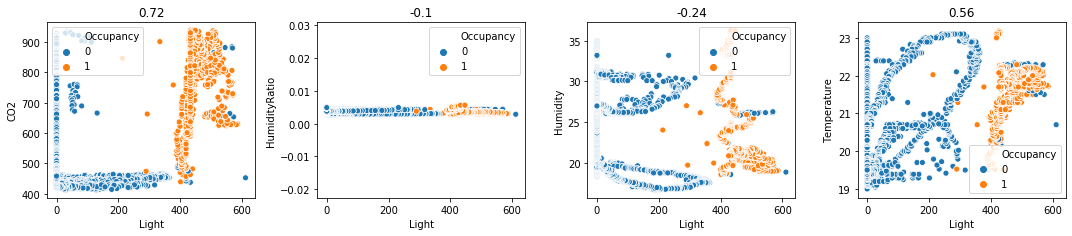

In [18]:
def scatter_fea_corr_classif_targ(df, features, target):
    
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()
    
scatter_fea_corr_classif_targ(occu, mi.index.tolist(), 'Occupancy')

Since it is so obvious that the feature 'Light' plays a significant role in the separation, and others are much less helpful, the feature 'Light' would be used alone to train and test the algorithm.

In [19]:
X = occu.loc[:, ['Light']]
y = occu['Occupancy'].astype(int)

LogisticRegerssion is firstly used for training and testing.

In [20]:
logi = LogisticRegression(random_state = 42)

Next, a graph would be drawn to show how the model performance goes along increasing number of training samples. The performance on both training and testing samples would be drawn on the same graph to get a clear view on how they differ.

Since the target is unbalanced, 'accuracy' is not an appropriate metric to measure the performace. 'balanced_accuracy' and 'f1' would be used.

The minimum number of training samples is set to be 50, while the maximum is set to be the 80% of the whole dataset.

In [21]:
train_sizes = np.linspace(start = 50, stop = X.shape[0] * 0.8, num = 6, dtype = int)

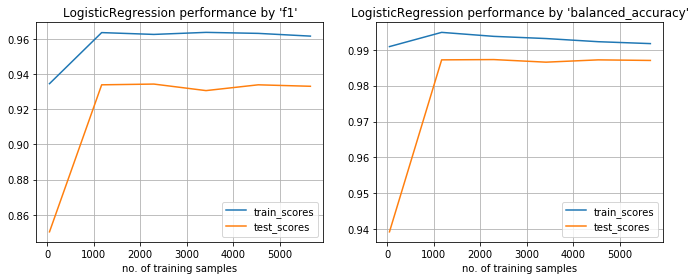

In [22]:
def plot_learning_curve(train_scores, test_scores):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
fig = plt.figure(figsize = (10, 4)) 

for i, metric in enumerate(['f1', 'balanced_accuracy']):
    train_sizes_abs, train_scores, test_scores = learning_curve(logi, X, y, train_sizes = train_sizes, 
                                                            scoring = metric, shuffle = True, random_state = 42)
    ax = fig.add_subplot(1, 2, i + 1)
    ax = plot_learning_curve(train_scores, test_scores)
    plt.title(f"LogisticRegression performance by '{metric}'")

plt.tight_layout()
plt.show()

The metric 'f1' and 'balanced_accuracy' were used for validating the performance.

The graph shows that the model achieved a surprisingly good result on both training and testing samples, considering only one feature being used.
1. The performance scores rose sharply along increasing number of training samples from 50 to about 1200. 
2. Being valued by 'f1', both scores reached a plateau when there were about 4500 samples used for training the model, with training one being almost 0.97 and testing one being almost 0.93;
3. The scores reached even higher to more than 0.98 when being valued by 'balanced_accuracy'.

Based on the Exploratory Data Analysis(EDA) and model performance studied above, the feature 'Light' alone was found to be enough in predicting the target(room occupancy). So that feature alone would be used to train the model with the algorithm of LogisticRegresson. The whole dataset would be used for training, and the model would be stored in a 'joblib' file for the future use.

In [23]:
logi.fit(X, y)
joblib.dump(logi, 'logi.joblib')

['logi.joblib']

Conclusion:
1. One key feature, 'Light' was discovered through EDA;
2. The feature 'Light' is so powerful that the model is able to achieve a rather good result by using that feature alone;
3. The satisfactory performances on 'f1' and 'balanced_accuracy' shows that the target of almost every single sample could be identified correctly, although the model was trained with a unbalanced dataset.